In [ ]:
import dv_processing as dv
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from scipy.interpolate import interp1d
import math
from datetime import timedelta

from IPython.display import Video

In [2]:
THRESHOLD = 3
Z = 144.5 - 4
H = 123 - 2
F = 2476 / 11
G = 9.787 * 100

## 0. Plotting utils

### 0.1 Visualize the data

In [3]:
def create_video(file_path, fps, output_file_path):
    """
    Create a video from an aedat4 file.
    Args:
        file_path (string): path to the video file
        fps (int): frames per second of the video
        output_file_path (string): path to save the output video
    Returns:
        frames (list of np.array): list of frames
        frame_times (list of float): list of frame times
    """
    reader = dv.io.MonoCameraRecording(file_path)
    frames = []
    frame_times = []

    while reader.isRunning():
        frame = reader.getNextFrame()
        start_time = reader.getTimeRange()[0]
        if frame is not None:
            frames.append(frame.image)
            frame_times.append((frame.timestamp - start_time) / 1e6)

    fig, ax = plt.subplots()
    ax.axis('off')
    ax.set_title('Free falling object video')

    initial_image = np.zeros((180, 240, 3), dtype=np.uint8)

    def init():
        ax.imshow(initial_image)
        return ax
    
    def animate(i):
        if i < len(frames):
            ax.imshow(frames[i])
    
    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frame_times), interval=1000 / fps, blit=False)
    ani.save(output_file_path, writer='ffmpeg')
    plt.close(fig)

    return frames, frame_times

### 0.2 Plot experiment results

In [4]:
def plot_experiment_results(times, predicted_velocities, true_velocities, output_file_path):
    """
    Plot the results of the free fall velocity prediction experiment.
    
    Args:
        times (list): List of times in seconds.
        predicted_velocities (list): List of predicted velocities in cm/s.
        true_velocities (list): List of true velocities in cm/s.
        output_file_path (string): Path to save the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(times, predicted_velocities, label='Predicted Velocities', color='blue')
    plt.plot(times, true_velocities, label='True Velocities', color='red')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Velocity (cm/s)')
    plt.title('Free Fall Velocity Prediction Experiment')
    plt.legend()
    plt.grid(True)

    if output_file_path is not None:
        plt.savefig(output_file_path)
    else:
        plt.show()

### 0.3 Visualize the experiment results

In [5]:
def create_result_video(times, velocities, true_velocities, frame_times, frames, fps, output_file_path):
    """
    Create a video for the free fall velocity prediction experiment.
    Args:
        times (list): List of times in seconds.
        velocities (list): List of predicted velocities in cm/s.
        true_velocities (list): List of true velocities in cm/s.
        frame_times (list): List of frame times in seconds.
        frames (list): List of frames.
        fps (int): Frames per second of the video.
        output_file_path (string): Path to save the video.
    """
    velocity_interpolator = interp1d(times, velocities, kind='linear', fill_value="extrapolate")

    finer_time_resolution = 10
    finer_frame_times = np.linspace(min(frame_times), max(frame_times), len(frame_times) * finer_time_resolution)
    finer_interpolated_velocities = velocity_interpolator(finer_frame_times)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Free Fall Velocity Prediction Experiment', fontsize=16)
    ax1.axis('off')
    object_image = ax1.imshow(np.zeros((180, 240, 3), dtype=np.uint8))
    ax1.set_title('Free falling object video')

    ax2.set_xlim(0, max(frame_times))
    ax2.set_ylim(min(min(velocities), min(true_velocities)), max(max(velocities), max(true_velocities)))
    ax2.plot(times, true_velocities, label='Theoretical Velocities', color='red')
    line, = ax2.plot([], [], lw=2, label='Predicted Velocities', color='blue')
    ax2.legend()
    ax2.set_title('Velocity Plot')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Velocity (cm/s)')
    ax2.grid(True)

    def init():
        line.set_data([], [])
        object_image.set_data(np.zeros((180, 240, 3), dtype=np.uint8))
        return line, object_image
    
    def animate(i):
        if i < len(frames):
            object_image.set_data(frames[i])
        line.set_data(finer_frame_times[:i*finer_time_resolution+1], finer_interpolated_velocities[:i*finer_time_resolution+1])
        return line, object_image
    
    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(frame_times), interval=1000 / fps, blit=True)
    ani.save(output_file_path, writer='ffmpeg')
    plt.close(fig)

## 1. Determine object position

In [6]:
def get_batch_average_position(events: dv.EventStore):
    """
    Calculate the average position of the batch of events
    Args:
        events (dv.EventStore): batch of events
    Returns:
        num_of_events (int): number of events in the batch
        batch_position (float): average position of the batch
    """
    num_of_events = 0
    batch_position = 0
    for ev in events:
        if ev.polarity() == 1:
            batch_position += ev.y()
            num_of_events += 1
    if num_of_events != 0:
        batch_position /= num_of_events
    return num_of_events, batch_position

def get_batch_median_position(events: dv.EventStore):
    """
    Calculate the median position of the batch of events
    Args:
        events (dv.EventStore): batch of events
    Returns:
        num_of_events (int): number of events in the batch
        median_position (float): median position of the batch
    """
    positions = [ev.y() for ev in events if ev.polarity() == 1]
    num_of_events = len(positions)
    if num_of_events == 0:
        return 0, 0
    median_position = np.median(positions)
    return num_of_events, median_position

import numpy as np

def get_batch_average_position_10_90_percentile(events: dv.EventStore):
    """
    Calculate the average position of the batch of events between the 10th and 90th percentiles
    Args:
        events (dv.EventStore): batch of events
    Returns:
        num_of_events (int): number of events in the batch
        batch_position (float): average position of the batch
    """
    positions = [ev.y() for ev in events if ev.polarity() == 1]
    num_of_events = len(positions)
    
    if num_of_events == 0:
        return 0, 0
    
    lower_percentile = np.percentile(positions, 10)
    upper_percentile = np.percentile(positions, 90)
    
    filtered_positions = [pos for pos in positions if lower_percentile <= pos <= upper_percentile]
    num_of_filtered_events = len(filtered_positions)
    
    if num_of_filtered_events == 0:
        return 0, 0
    
    average_position = np.mean(filtered_positions)
    
    return num_of_filtered_events, average_position

## 2. Compute velocity

In [7]:
def recording_to_batches(file_path, duration_ms=10):
    """
    Convert an aedat4 file to batches of events with a fixed duration.
    Args:
        file_path (string): path to the aedat4 file
        duration_ms (int): duration of each batch in milliseconds
    Returns:
        batches (list of dv.EventStore): list of batches
    """
    reader = dv.io.MonoCameraRecording(file_path)
    store = dv.EventStore()
    batches = []

    while reader.isRunning():
        # Read batch of events
        events = reader.getNextEventBatch()
        if events is not None:
            for ev in events:
                store.push_back(ev)

    slicer = dv.EventStreamSlicer()

    def slicing_callback(events: dv.EventStore):
        batches.append(events)

    slicer.doEveryTimeInterval(timedelta(milliseconds=duration_ms), slicing_callback)
    slicer.accept(store)

    return batches


In [8]:
def predict_velocity(batches, z, f, threshold, batch_position_method=get_batch_average_position):
    """
    Predict the velocity of the object
    Args:
        batches (list of dv.EventStore): list of batches of eventss
        z (float): distance between the camera and the object in centimeters
        f (float): distance between the image sensor and the lens in pixels
        threshold (int): number of events in a batch
        batch_position_method (function): method to calculate the position of the batch
    Returns:
        times (list): list of times in seconds
        velocities (list): list of velocities in m/s
    """
    times = []
    velocities = []
    pre_time = 0
    pre_y_position = 0
    start_time = batches[0].getLowestTime()

    for events in batches:
        if events is not None:
            batch_time = (events.getHighestTime() + events.getLowestTime()) / 2
            num_of_events, batch_y_position = batch_position_method(events)

        if pre_time != 0 and pre_y_position != 0 and num_of_events > threshold:
            distance = float(batch_y_position - pre_y_position) * z / f

            time = (batch_time - pre_time) / 1e6
            if time != 0:
                velocity = distance / time
                velocities.append(velocity / 100)


                times.append((batch_time - start_time) / 1e6)

        pre_time = batch_time
        pre_y_position = batch_y_position

    return times, velocities

In [9]:
def true_velocity(times, v0, g, h, e=0.86):
    """
    Calculate the true velocity of the object considering bounces,
    with falling velocities positive and rising velocities negative.

    Args:
        times (list): List of times in seconds.
        v0 (float): Initial velocity in m/s (positive if falling, negative if rising).
        g (float): Acceleration due to gravity in cm/s^2 (positive value).
        h (float): Initial height of the object in cm.
        e (float): Coefficient of restitution (default is 1.0 for perfectly elastic collision).

    Returns:
        velocities (list): List of velocities in m/s at the specified times.
    """
    velocities = []

    # h - v0*t + 0.5*g*t^2 = 0
    a = 0.5 * g
    b = v0
    c = h
    delta = b**2 + 4 * a * c
    t_first_impact = (-b + math.sqrt(delta)) / (2 * a)

    impact_times = [t_first_impact]
    v_before_impact = v0 + g * t_first_impact
    v_after_impact = -e * v_before_impact
    impact_velocities = [v_after_impact]
    t_previous = t_first_impact
    v_previous = v_after_impact

    # Tính thời gian rơi + vận tốc sau va chạm
    while t_previous < max(times):
        t_up = -v_previous / g 
        t_down = t_up
        t_total = t_up + t_down
        t_next = t_previous + t_total

        v_before_impact = v_previous + g * (t_up + t_down)

        v_after_impact = -e * v_before_impact

        impact_times.append(t_next)
        impact_velocities.append(v_after_impact)

        v_previous = v_after_impact
        t_previous = t_next

    for t in times:
        num_impacts = sum(1 for impact_time in impact_times if impact_time <= t)

        if num_impacts == 0:
            # Before the first impact
            v = v0 + g * t
        else:
            # After one or more impacts
            t_since_last_impact = t - impact_times[num_impacts - 1]
            v_initial = impact_velocities[num_impacts - 1]

            if v_initial < 0:
                v = v_initial + g * t_since_last_impact
                if v >= 0:
                    t_to_peak = -v_initial / g
                    t_since_peak = t_since_last_impact - t_to_peak
                    v = 0 + g * t_since_peak 
            else:
                v = v_initial + g * t_since_last_impact

        velocities.append(v / 100)

    return velocities

def root_mean_squared_error(predicted_velocities, true_velocities):
    """
    Calculate the root_mean squared error (RMSE) between the predicted velocities and the true velocities.
    Args:
        predicted_velocities (list): List of predicted velocities.
        true_velocities (list): List of true velocities.
    Returns:
        root_mean_squared_error (float): Mean squared error.
    """
    squared_errors = [(predicted - true) ** 2 for predicted, true in zip(predicted_velocities, true_velocities)]
    mean_squared_error = sum(squared_errors) / len(squared_errors)
    root_mean_squared_error = math.sqrt(mean_squared_error)
    return root_mean_squared_error


# 3. Experiments

In [10]:
batches = recording_to_batches('../data/event_3.aedat4', duration_ms=15)
batches

[EventStore containing 3 events within 7848µs duration; time range within [1728294301808053; 1728294301815901],
 EventStore containing 1 events within 0µs duration; time range within [1728294301827621; 1728294301827621],
 EventStore containing 7 events within 7643µs duration; time range within [1728294301840394; 1728294301848037],
 EventStore containing 6 events within 13103µs duration; time range within [1728294301854559; 1728294301867662],
 EventStore containing 6 events within 10069µs duration; time range within [1728294301871728; 1728294301881797],
 EventStore containing 3 events within 7337µs duration; time range within [1728294301883728; 1728294301891065],
 EventStore containing 10 events within 12907µs duration; time range within [1728294301898413; 1728294301911320],
 EventStore containing 12 events within 11172µs duration; time range within [1728294301914635; 1728294301925807],
 EventStore containing 16 events within 11643µs duration; time range within [1728294301931203; 172829

## 3.1 Visualize the data

In [11]:
frames, frame_times = create_video('../data/frame_4.aedat4', 10, 'object_video_4.mp4')
Video('../results/object_video_4.mp4')

## 3.2 Predict velocities and Visualize the result

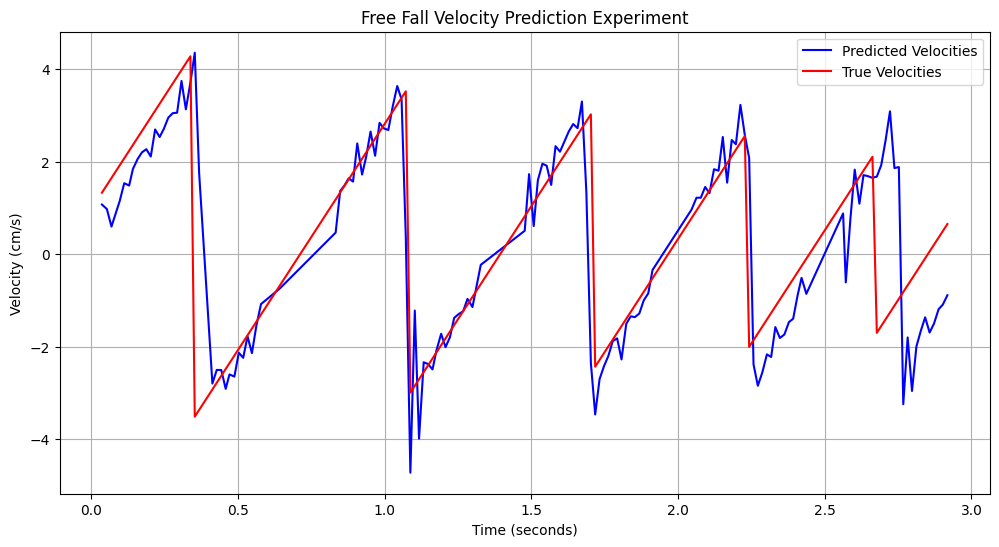

In [31]:
times, velocities = predict_velocity(batches, z=Z, f=F, threshold=3, batch_position_method=get_batch_average_position_10_90_percentile)
true_velocities = true_velocity(times, v0=velocities[1] * 100, g=G, h=90.34, e=0.84)
# plot_experiment_results(times, velocities, true_velocities, output_file_path='../results/velocity_plot_4.png')
plot_experiment_results(times, velocities, true_velocities, output_file_path='velocity_plot_4.png')

In [32]:
rmse = root_mean_squared_error(
    predicted_velocities=velocities,
    true_velocities=true_velocities
)
print(f'Mean Squared Error: {rmse}')

Mean Squared Error: 1.3934832447256722


In [33]:
create_result_video(times, velocities, true_velocities, frame_times, frames, fps=10, output_file_path='../results/result_4.mp4')
Video('result_4.mp4')

In [ ]:
print(f'Predicted velocities: {velocities}')
print(f'True velocities: {true_velocities}')

Predicted velocities: [147.39766115056392, 245.60244177845618, 185.00586414247334, 281.0659306702493, 263.1182873326941, 259.5557472705717, 379.9634384831223, 262.81778760309504, 344.0159865712341, 313.44765959511363, 358.70633788866644, 320.4522318118078, 361.3592870747777, 318.73584221986084, 384.69312898597224, 393.1463398288076, 357.97791251601535, 422.75901622230003, 392.9655457040216, 378.82210995368496, 437.37740508534677, 411.2758309818985, 405.526425305309, 444.81219675521805, 530.422234015912, 380.7885827301245, -416.10504675785825, -462.4788186396769, -364.4418763680256, -322.1907134253942, -265.85960990677586, -357.71059836853857, -228.19604395223638, -174.1198711767332, 219.5948208908002, 229.58583419415388, 276.40117942131786, 227.41107943541823, 245.95738779080082, 294.1382109521244, 292.6635721090158, 316.5795205287641, 252.2488610576472, 301.2477026046454, 330.70920480732264, 338.9249237554642, 342.4541240387357, 359.642698696654, 375.62857383504877, 320.3523318866045,